## Optimized RBF_SVM model for trainning set engineering.
## Author: Zhi Li
## Date: 02/06/2019

In [1]:
import os, fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.svm import SVC
import pydotplus
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, learning_curve
from sklearn.cross_validation import cross_val_score
import optunity
import optunity.metrics

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Data input
file = "PostRunFulldataset.csv"
df = pd.read_csv(file)
Inchi_df = pd.read_csv("Organic Inchikey.csv")
Inchidict = dict(zip(Inchi_df['Chemical Name'], Inchi_df['InChI Key (ID)']))

In [3]:
# Generate input, output and reference dataframe
X = df.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'])
y = df.filter(['_out_crystalscore'])
inchikey = df.filter(['RunID_vial', '_rxn_organic-inchikey']) 

In [4]:
amine_list = ['Phenethylammonium iodide', 'n-Butylammonium iodide', 'Ethylammonium Iodide', 'Methylammonium iodide', \
               'Guanidinium iodide', 'Acetamidinium iodide', 'Formamidinium Iodide', 'Imidazolium Iodide']

In [5]:
ammonium = 'Ethylammonium Iodide'

# Find ammonium index in original dataframe
inchi = Inchidict[ammonium]
ammonium_index = inchikey.index[inchikey['_rxn_organic-inchikey'] == inchi].tolist()

# pick target ammonium
X_ammonium = X.filter(ammonium_index, axis = 0)
y_ammonium = y.filter(ammonium_index, axis = 0)
y_ammonium = (y_ammonium.replace([1,2,3],0)).replace(4,1) # turned into binary classification

# index of formic acid conc falls in certain range (4)
forange = []
for i in range(3):
    forange.append(X_ammonium.index[(X_ammonium['_rxn_M_acid']>=(2*i)) & (X_ammonium['_rxn_M_acid']<(2*i+2))].tolist())
forange.append(X_ammonium.index[X_ammonium['_rxn_M_acid']>=6].tolist())

#slice the data into 4 region
X_ammonium = X_ammonium.drop(['_rxn_M_acid'], axis = 1)
X_ammonium_ = []
y_ammonium_ = []
for i in range(4):
    X_ammonium_.append(X_ammonium.filter(forange[i], axis = 0))
    y_ammonium_.append(y_ammonium.filter(forange[i], axis = 0))

In [6]:
# Standarize the features
for i in range(4):
    x = StandardScaler().fit_transform(X_ammonium_[i])
    X_ammonium_[i] = pd.DataFrame(x, index = X_ammonium_[i].index, columns = X_ammonium_[i].columns)    

## Fit SVM model

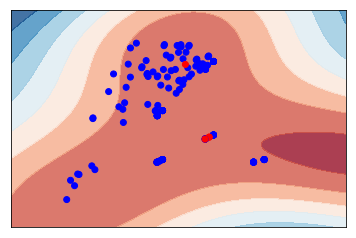

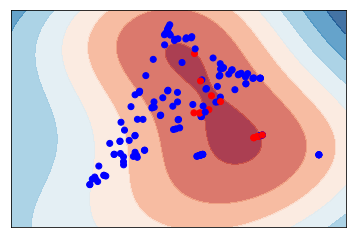

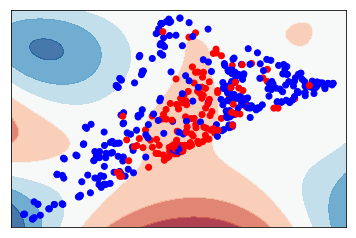

In [31]:
clf = SVC(C=100000,gamma=0.1,cache_size=5000,max_iter=-1,kernel='rbf',\
              decision_function_shape='ovr', probability=True)

for i in range(1,4):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#0000FF', '#FF0000'])
    
    X_train, X_test, y_train, y_test = train_test_split(X_ammonium_[i], y_ammonium_[i],test_size=0.2,random_state=42)
    x_min, x_max = X_ammonium_[3]['_rxn_M_inorganic'].min()-0.2, X_ammonium_[3]['_rxn_M_inorganic'].max()+0.2
    y_min, y_max = X_ammonium_[3]['_rxn_M_organic'].min()-0.2, X_ammonium_[3]['_rxn_M_organic'].max()+0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    clf.fit(X_train, y_train)
    
    # Plot the decision boundary, color of region. 
    Z = -clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    
    # Plot the training points
    points = np.array(X_ammonium_[i])
    points = np.append(points, np.array(y_ammonium_[i]), 1)
    ax.scatter(points[:,0], points[:,1], c=points[:,2], cmap=cm_bright)
    #ax.scatter(points[:,0][points[:,2]==0], points[:,1][points[:,2]==0], \
               #c='blue')
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    plt.savefig('SVM_slice_'+ammonium+'_'+ str(i) +'_.svg', format = 'svg', transparent=True)

In [17]:
np.shape(clf.decision_function(np.c_[xx.ravel(), yy.ravel()]))

(68376,)